In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import metrics

In [6]:
data1=pd.read_csv('/content/usa_era5_daily_2023_full_year_clean.csv')
data2=pd.read_csv('/content/usa_era5_daily_jan_jun_2024_clean.csv')
data3=pd.read_csv('/content/usa_era5_daily_jul_dec_2024_clean.csv')

In [7]:
data1.head(3)


,system:index,SW_down,U10,V10,date,dewpoint_2m_C,precip_mm,temperature_2m_C,.geo
0,0,358572.688423,0.856036,1.519011,2023-01-01,8.574673,0.018524,12.572876,"{""type"":""MultiPoint"",""coordinates"":[]}"
1,1,248082.956500,-0.202985,1.884777,2023-01-02,11.154796,0.111686,13.810609,"{""type"":""MultiPoint"",""coordinates"":[]}"
2,2,310435.552352,1.616880,1.662760,2023-01-03,9.473022,0.394770,13.999925,"{""type"":""MultiPoint"",""coordinates"":[]}"


In [8]:
data1.shape

(365, 9)

In [9]:
data2.head(3)


,system:index,SW_down,U10,V10,date,dewpoint_2m_C,precip_mm,temperature_2m_C,.geo
0,0,424756.794457,0.488705,-0.747651,2024-01-01,-0.384964,0.009473,4.855562,"{""type"":""MultiPoint"",""coordinates"":[]}"
1,1,406614.186786,0.038604,-0.371658,2024-01-02,-1.427726,0.028280,3.826567,"{""type"":""MultiPoint"",""coordinates"":[]}"
2,2,388675.294918,0.407245,-0.358897,2024-01-03,-0.196882,0.086211,4.029839,"{""type"":""MultiPoint"",""coordinates"":[]}"


In [10]:
data2.shape

(181, 9)

In [11]:
data3.head(3)

,system:index,SW_down,U10,V10,date,dewpoint_2m_C,precip_mm,temperature_2m_C,.geo
0,0,1.075346e+06,-0.629387,0.817166,2024-07-01,18.490134,0.093233,26.799607,"{""type"":""MultiPoint"",""coordinates"":[]}"
1,1,1.100196e+06,-0.608696,1.880262,2024-07-02,17.591511,0.036208,27.448626,"{""type"":""MultiPoint"",""coordinates"":[]}"
2,2,9.569655e+05,-0.484483,1.976321,2024-07-03,19.700821,0.095633,28.097770,"{""type"":""MultiPoint"",""coordinates"":[]}"


In [12]:
data3.shape

(183, 9)

In [13]:
df=pd.concat([data1,data2,data3])

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 729 entries, 0 to 182
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   system:index      729 non-null    int64  
 1   SW_down           729 non-null    float64
 2   U10               729 non-null    float64
 3   V10               729 non-null    float64
 4   date              729 non-null    object 
 5   dewpoint_2m_C     729 non-null    float64
 6   precip_mm         729 non-null    float64
 7   temperature_2m_C  729 non-null    float64
 8   .geo              729 non-null    object 
dtypes: float64(6), int64(1), object(2)
memory usage: 57.0+ KB


In [15]:
df['date'] = pd.to_datetime(df['date'])

In [16]:
df.head(3)

,system:index,SW_down,U10,V10,date,dewpoint_2m_C,precip_mm,temperature_2m_C,.geo
0,0,358572.688423,0.856036,1.519011,2023-01-01,8.574673,0.018524,12.572876,"{""type"":""MultiPoint"",""coordinates"":[]}"
1,1,248082.956500,-0.202985,1.884777,2023-01-02,11.154796,0.111686,13.810609,"{""type"":""MultiPoint"",""coordinates"":[]}"
2,2,310435.552352,1.616880,1.662760,2023-01-03,9.473022,0.394770,13.999925,"{""type"":""MultiPoint"",""coordinates"":[]}"


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 729 entries, 0 to 182
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   system:index      729 non-null    int64         
 1   SW_down           729 non-null    float64       
 2   U10               729 non-null    float64       
 3   V10               729 non-null    float64       
 4   date              729 non-null    datetime64[ns]
 5   dewpoint_2m_C     729 non-null    float64       
 6   precip_mm         729 non-null    float64       
 7   temperature_2m_C  729 non-null    float64       
 8   .geo              729 non-null    object        
dtypes: datetime64[ns](1), float64(6), int64(1), object(1)
memory usage: 57.0+ KB


In [18]:
df=df.drop(['system:index','.geo'],axis=1)
df.shape

(729, 7)

In [19]:
df.duplicated().sum()

np.int64(0)

In [20]:
df.isna().sum().max()

0

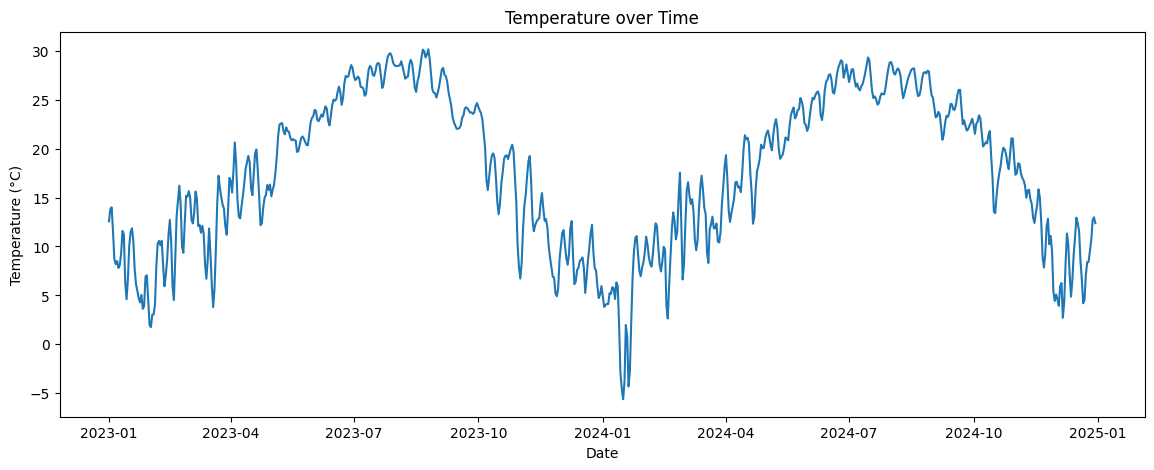

In [21]:
plt.figure(figsize=(14,5))
sns.lineplot(x=df['date'], y=df['temperature_2m_C'])
plt.title("Temperature over Time")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.show()

In [22]:
features = ['temperature_2m_C']
data = df[features].values

In [23]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [24]:
n_past =  30
n_future =  1
n_features = data.shape[1]


In [25]:
X, y = [], []
for i in range(n_past, len(data_scaled) - n_future + 1):
    X.append(data_scaled[i - n_past:i])
    y.append(data_scaled[i:i + n_future])

In [26]:
X, y = np.array(X), np.array(y)
y = y.reshape(y.shape[0], n_future * n_features)

In [27]:
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (559, 30, 1) (559, 1)
Test shape: (140, 30, 1) (140, 1)


In [28]:
model = Sequential([
    LSTM(128, activation='relu', input_shape=(n_past, n_features), return_sequences=True),
    Dropout(0.2),
    LSTM(64, activation='relu'),
    Dropout(0.2),
    Dense(n_features, activation='linear')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [29]:
model.compile(optimizer='adam', loss='mse')

In [30]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [31]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 0.2848 - val_loss: 0.0995
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0426 - val_loss: 0.0245
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0193 - val_loss: 0.0107
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0166 - val_loss: 0.0043
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0185 - val_loss: 0.0122
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0150 - val_loss: 0.0039
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0150 - val_loss: 0.0045
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0153 - val_loss: 0.0075
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0163 - val_loss: 0.0093
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - loss: 0.0170 - val_loss: 0.0031
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.0154 - val_loss: 0.0047
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0

In [33]:
history_loss = pd.DataFrame(history.history)  # history هو اللي راجع من model.fit
history_loss = history_loss[['loss', 'val_loss']].reset_index()  # إعادة ترتيب index

# رسم المنحنى
fig = px.line(
    history_loss,
    x='index',           # يمثل Epoch
    y=['loss', 'val_loss'],
    labels={'index': 'Epochs', 'value': 'Loss'},
    title='Loss & Val Loss'
)
fig.update_layout(width=700, height=500)
fig.show()


In [34]:
y_pred = model.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step


In [35]:
from sklearn.metrics import mean_absolute_error, r2_score

feature_names = features  # ['SW_down','U10','V10','dewpoint_2m_C','precip_mm','temperature_2m_C']

# Reshape y_test and y_pred
y_pred_reshaped = y_pred.reshape(-1, n_future, n_features)
y_test_reshaped = y_test.reshape(-1, n_future, n_features)

for i, feature in enumerate(feature_names):
    y_true = y_test_reshaped[:,:,i].flatten()
    y_pred_flat = y_pred_reshaped[:,:,i].flatten() # Use a different variable name to avoid confusion

    mse = mean_squared_error(y_true, y_pred_flat)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred_flat)
    r2 = r2_score(y_true, y_pred_flat)

    print(f"{feature}: MSE={mse:.4f}, RMSE={rmse:.4f}, MAE={mae:.4f}, R2={r2:.4f}")

temperature_2m_C: MSE=0.0065, RMSE=0.0808, MAE=0.0642, R2=0.8335


In [40]:
model.save("weather_lstm_model.h5")

In [46]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
import os
from tensorflow.keras.models import load_model
import joblib

# تأكد إن المجلد موجود
save_path = "/content/drive/MyDrive/ML_Models"
os.makedirs(save_path, exist_ok=True)

# حفظ المودل
model.save(os.path.join(save_path, "weather_lstm_model.h5"))

# حفظ الـ scaler
joblib.dump(scaler, os.path.join(save_path, "scaler.save"))

print("✅ Model and scaler saved to Google Drive!")


✅ Model and scaler saved to Google Drive!
